---
title: "Data analysis"
icon: "chart-line"
---

**Data Analysis Agents** use language models to write and run Python code for exploring and visualizing data. This guide shows how to analyze a CSV file using a LangChain agent with code execution capabilities.

## 1. Configure the sandbox

In [ ]:
# todo: move to langchain_daytona
from langchain.sandboxes import DaytonaSandboxManager
import csv

filename = "sales_data.csv"
data = [
    ["Date", "Product", "Units Sold", "Revenue"],
    ["2025-08-01", "Widget A", 10, 250],
    ["2025-08-02", "Widget B", 5, 125],
    ["2025-08-03", "Widget A", 7, 175],
    ["2025-08-04", "Widget C", 3, 90],
    ["2025-08-05", "Widget B", 8, 200]
]

with open(filename, mode="w", newline="") as file:
    writer = csv.writer(file)
    writer.writerows(data)


# TODO: Fix life cycle management for the sandbox
sandbox_manager = DaytonaSandboxManager()
sandbox = sandbox_manager.create()
print(sandbox.get_capabilities())

## 2. Configure the agent

We initialize a language model and create a DataAnalysisAgent, passing it:
* the sandbox
* the model
* available tools (run_code, exec)
* any files to attach

In [ ]:
import uuid
from langchain.agents.data_analysis import create_data_analysis_agent
from langchain.chat_models import init_chat_model

thread_id = uuid.uuid4()


model = init_chat_model('anthropic:claude-3-7-sonnet-latest', max_tokens=32_000)

data_analysis_agent = create_data_analysis_agent(
    model,
    sandbox,
    tools=['run_code', 'exec'],
    files=[{
        "source": "sales_data.csv",
        "destination": "./data/sales_data.csv",
    }]
)

## 3. Run the agent

In [ ]:
response = data_analysis_agent.invoke(
    {
        "messages": [{
            "role": "user",
            "content": "Make a beautiful plot of provided data using matplotlib and add some summarys stats while you're at it.",
        }]
    },
    config={"configurable": {"thread_id": thread_id}}
)
print(response['messages'][-1].content)

## Sales Data Analysis Summary

I've created a comprehensive analysis of the sales data with a beautiful dashboard visualization. Here are the key findings:

### Overall Summary Statistics:
- **Total Revenue**: $840
- **Total Units Sold**: 33
- **Average Price Per Unit**: $25.45
- **Best Selling Product**: Widget A (17 units)
- **Highest Revenue Product**: Widget A ($425)

### Product-Specific Analysis:

**Widget A**:
- Total Units Sold: 17 units
- Total Revenue: $425
- Average Price Per Unit: $25.00
- Sales Trend: Decreasing or Stable (from 10 to 7 units)

**Widget B**:
- Total Units Sold: 13 units
- Total Revenue: $325
- Average Price Per Unit: $25.00
- Sales Trend: Increasing (from 5 to 8 units)

**Widget C**:
- Total Units Sold: 3 units
- Total Revenue: $90
- Average Price Per Unit: $30.00
- Only appeared in sales on one day (2025-08-04)

### Key Insights:
1. Widget A is the most popular product in terms of both units sold and revenue generated.
2. Widget C has the highest price pe

In [9]:
response = data_analysis_agent.invoke(
    {
        "messages": [{
            "role": "user",
            "content": "Did you save the generated plot to a file? if not please do and put it in sales_analysis.png",
        }]
    },
    config={"configurable": {"thread_id": thread_id}}
)

In [10]:
f = sandbox.download_file('./sales_analysis.png')

In [12]:
from IPython.display import Image

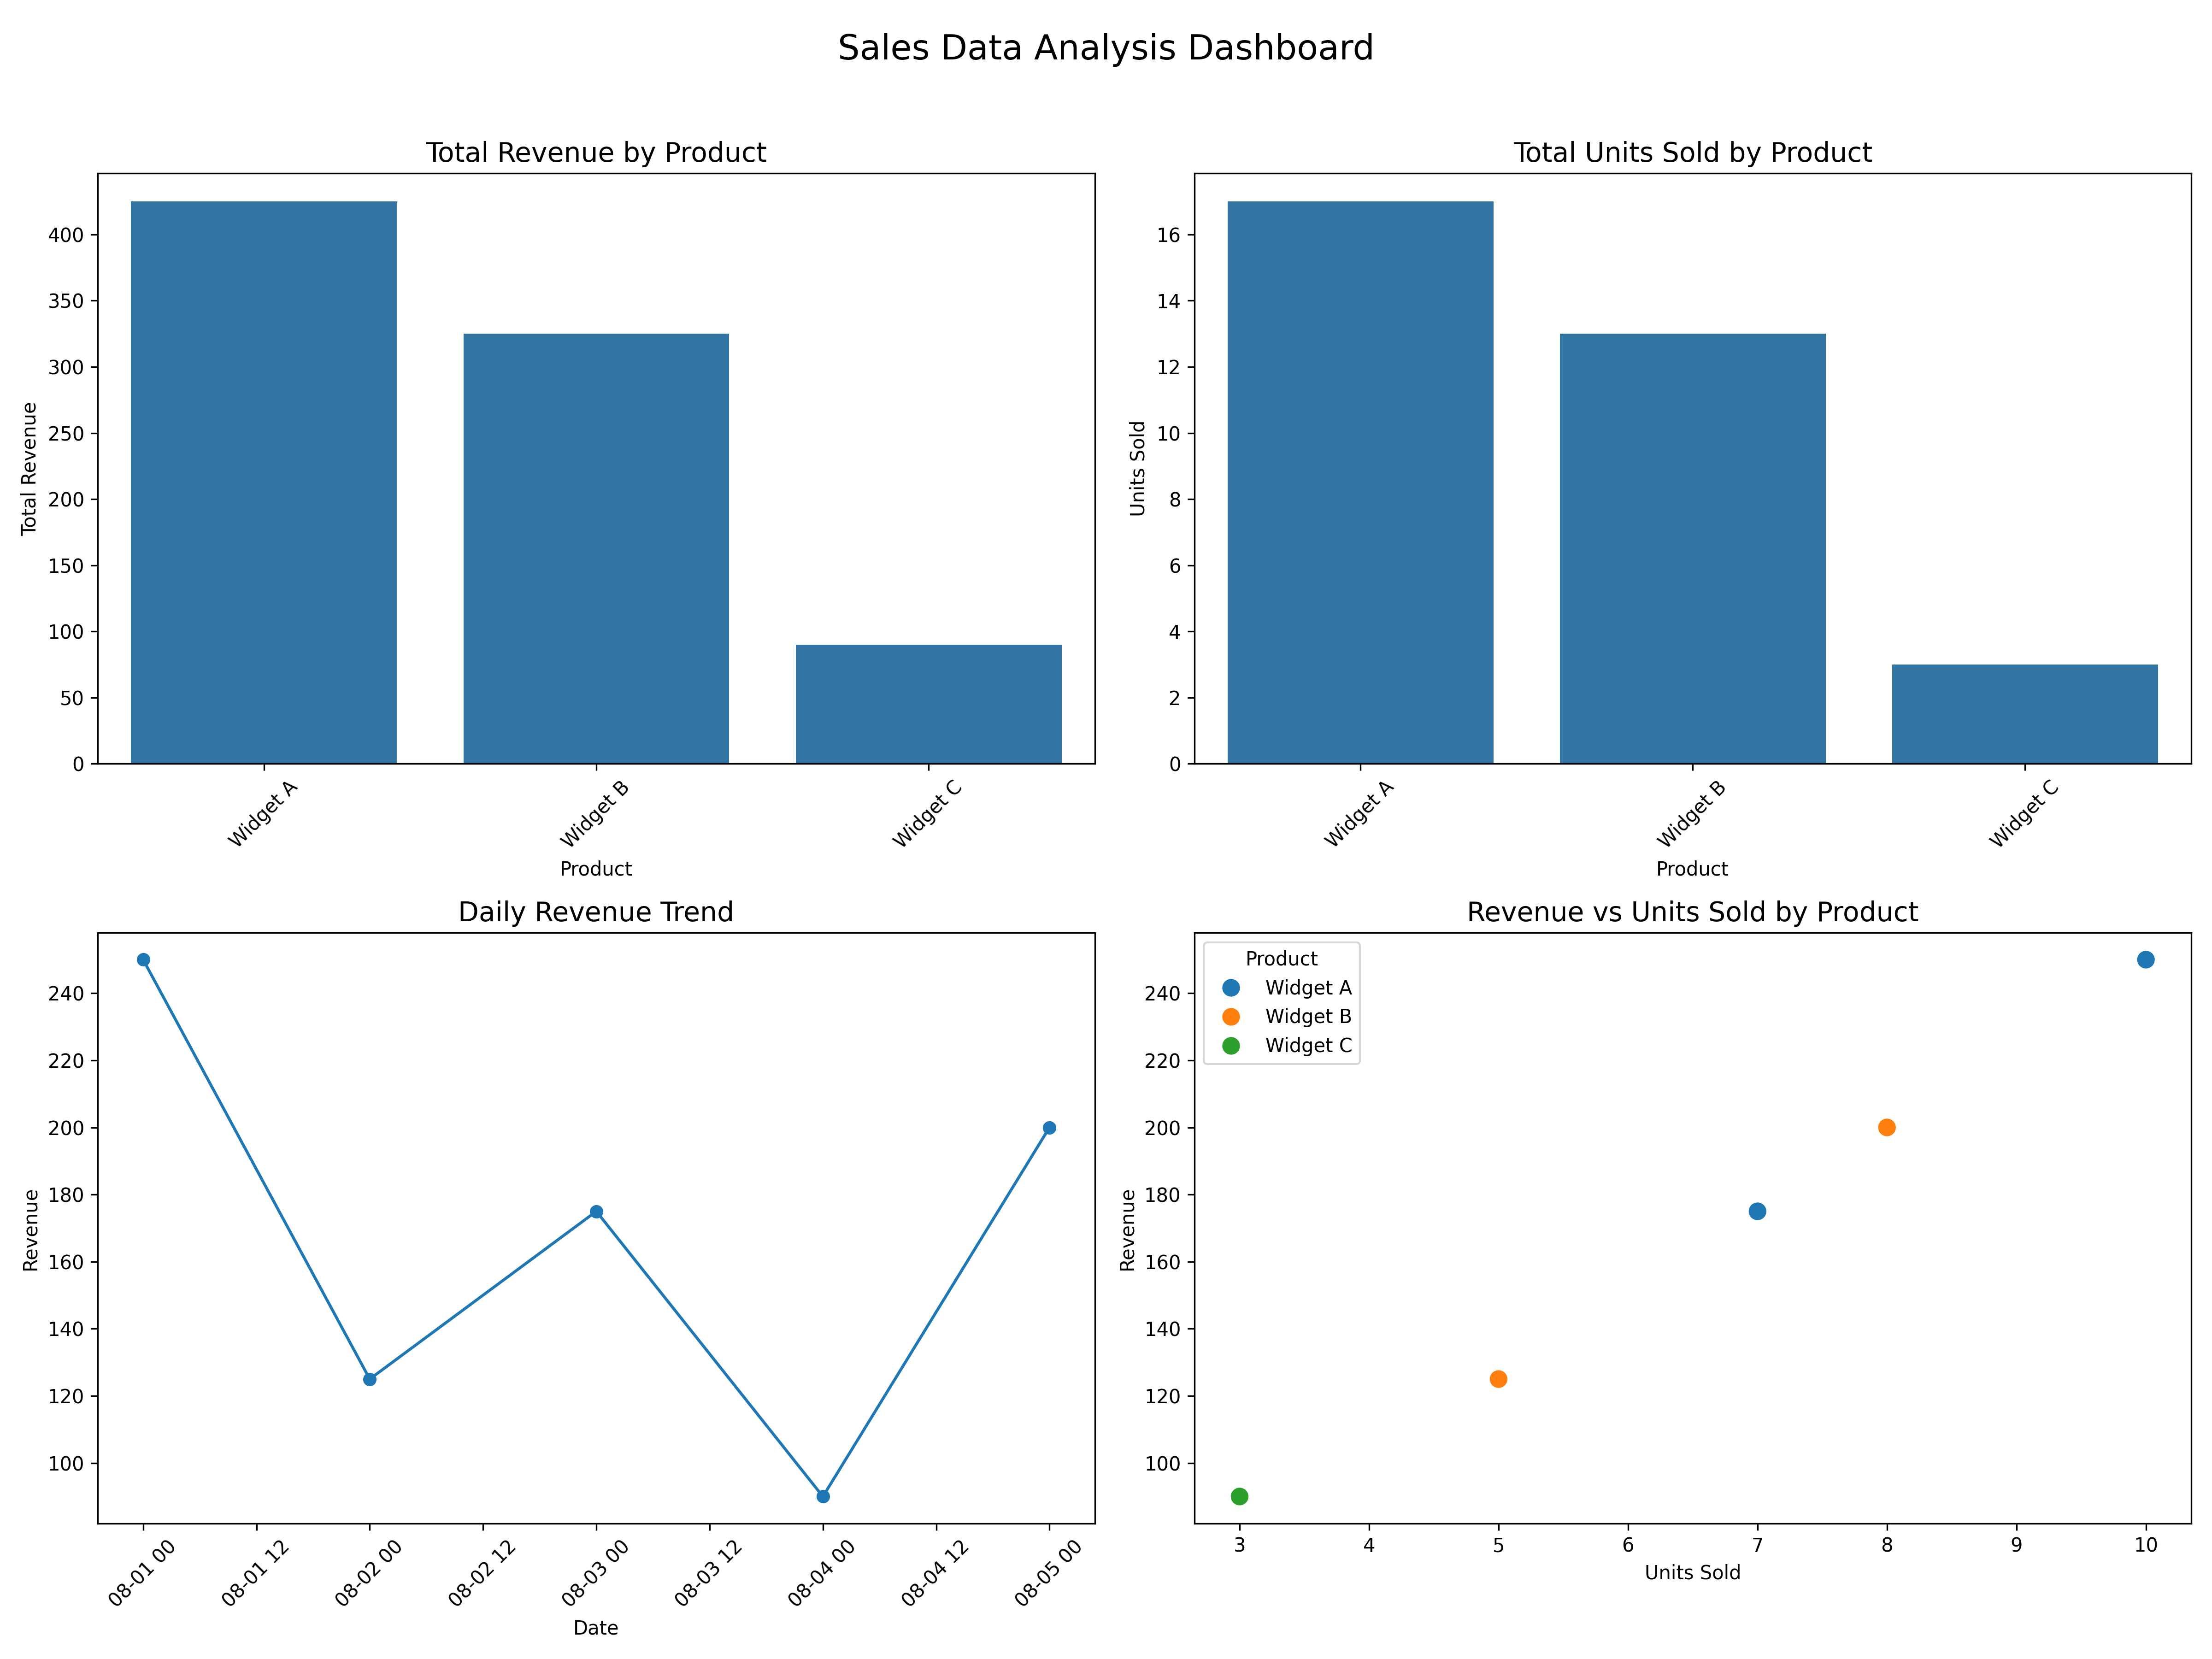

In [13]:
Image(f)

<Warning title="Sandbox Security">

The sandboxed environment allows for arbitrary code execution. To ensure safety:

* **Never place secrets (e.g., API keys, credentials) or sensitive files inside the sandbox**.
  The agent operates on untrusted input, and **prompt injection attacks can exfiltrate anything inside the sandbox**.

* The sandbox **does protect your local/production machine** from harmful code (e.g., file deletion, network access), as code execution is fully isolated.
</Warning>